In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import Affine2D
from matplotlib.ticker import MultipleLocator, MaxNLocator
import seaborn as sns
from ast import literal_eval
from pathlib import Path
from itertools import product
from joblib import Parallel, delayed

sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (18, 5)

In [2]:
# load all files
df = pd.concat((pd.read_csv(f) for f in Path("results").glob("*.csv") if f.stat().st_size > 0 ), ignore_index=True)
df = df.drop("params",axis=1)

# eval columns
struct_cols = ['score_set',"stage_clf_params"]
df[struct_cols] = df[struct_cols].map(literal_eval)
df.fillna({"stage_loss":"expected_entropy"},inplace=True)

# clean some stuff
df["clf_variant"] = df.clf.str.cat(df.clf_variant, sep="_", na_rep="").str.rstrip("_")

In [3]:
df.stage_loss.value_counts(dropna=False)

stage_loss
expected_entropy     19084
soft_ranking_loss     1922
Name: count, dtype: int64

<Axes: xlabel='stage', ylabel='train_ent'>

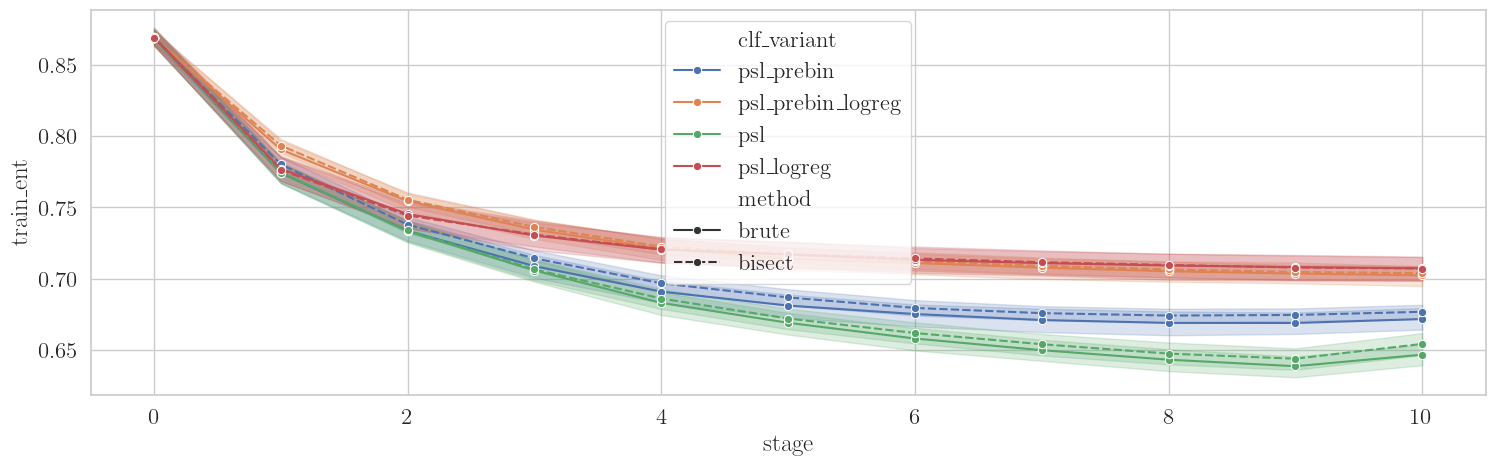

In [4]:
# 41945, 43979, 42900
df_ = df[
(df.dataset == 41945)
& (df.score_set==(-3, -2, -1, 1, 2, 3)) 
& (df.lookahead.isin({None,1})) 
& (df.stage_clf_params.isin({None, ('calibration_method', 'isotonic')}))
]

fig,axes = plt.subplots()
sns.lineplot(data=df_, x="stage", y="train_ent", hue="clf_variant", style="method", marker="o", ax=axes)

In [5]:
%%capture

@delayed
def create_figure(sample, metric):
    sns.set(font_scale=1.5,rc={'text.usetex' : True})
    sns.set_style("whitegrid")
    plt.rc('font', **{'family': 'serif'})
    plt.rcParams["figure.figsize"] = (18, 5)
    fig, axes = plt.subplots()
    sns.lineplot(data=df_, x="stage", y=f"{sample}_{metric}", hue=hue, style=variant, marker="o", ax=axes)
    fig.savefig(f"../fig/{dataset} {variant} {sample}_{metric}.png", bbox_inches="tight")

variants = [("clf_variant", "score_set"), ("clf_variant", "method"), ("clf_variant", "lookahead"), ("clf_variant", "stage_clf_params"), ("clf_variant", "stage_loss")]
variants = [("clf_variant", "stage_loss")]
fixed = dict(score_set = (-3,-2,-1,1,2,3),
             lookahead = 1,
             stage_clf_params = ('calibration_method', 'isotonic'),
             method = "bisect",
             stage_loss = np.nan)

for hue, variant in variants:
    for dataset in ["thorax", 41945, 42900]:
        df_ = df[df.dataset == dataset]

        # Generate a mask for all rows that should be kept
        mask = pd.Series([True] * len(df_), index=df_.index)
        
        # Iterate through the items in fixed, but vectorize the checks where possible
        for k, v in fixed.items():
            if k != variant:
                # Update the mask: True if the value is v or None, False otherwise
                # Note: We use | for a bitwise OR to combine boolean masks
                mask &= (df_[k].isin([v]) | df_[k].isnull())
        df_ = df_[mask]

        Parallel(12)(
            create_figure(sample, metric)
            for sample, metric 
            in product(["train", "test"], ["ent", "acc", "wloss", "bacc", "roc", "brier"]))

FileNotFoundError: [Errno 2] No such file or directory: '../fig/thorax stage_loss train_wloss.png'